Checking the counts of the images

In [128]:
import os

directory = "annotations" # directory where the txt files are located
files = os.listdir(directory) # get the list of all files in the directory

counts = []
for file in files:
    if file.endswith(".txt"): # check if the file is a txt file
        path = os.path.join(directory, file) # get the full path of the file
        with open(path, 'r') as f:
            num_rows = sum(1 for line in f) # count the number of rows in the file
            print(f"{file}: {num_rows}")
            counts.append(num_rows)

total_samples = sum(counts)
class_weights = np.array([total_samples / count for count in counts])
class_weights /= class_weights.sum() # normalize the weights to sum to 1
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f'example class init weights: {class_weights}')

night.txt: 598
people.txt: 6403
baby.txt: 95
female.txt: 3227
flower.txt: 761
car.txt: 319
portrait.txt: 3121
bird.txt: 360
clouds.txt: 1095
dog.txt: 448
male.txt: 2979
river.txt: 120
tree.txt: 525
sea.txt: 173
example class init weights: [0.04211008 0.00393282 0.26507189 0.00780348 0.03309045 0.0789399
 0.00806851 0.06994953 0.0229971  0.05620944 0.00845311 0.20984858
 0.04796539 0.14555971]


## Multi-class classifier

In [131]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torch.backends.mps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torchvision.transforms as transforms

import pandas as pd

In [106]:
#--- hyperparameters ---
N_EPOCHS = 10
LR = 0.001
DROPOUT_RATE = 0.3

#--- fixed constants ---
NUM_CLASSES = 14
DATA_DIR = 'dataset/%s'
NUM_CHANNELS = 3
WIDTH, HEIGHT = 128, 128
MEAN = [0.45183619, 0.4171191, 0.3778775 ]
SD = [0.24016619, 0.23024313, 0.22750713]

In [102]:
train_transform = transforms.Compose([
                                        #transforms.RandomHorizontalFlip(),
                                        #transforms.RandomResizedCrop(128),
                                        #transforms.Grayscale(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(MEAN, SD)])
val_transform = transforms.Compose([
                                        #transforms.Grayscale(),
                                        #transforms.Resize(256),
                                        #transforms.CenterCrop(128),
                                        transforms.ToTensor(),
                                        transforms.Normalize(MEAN, SD)])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(MEAN, SD)])

low_freq_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=128),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, SD)
])


## V3

In [143]:
#def stratified_train_test_split(data, labels, test_size=0.2, random_state=42):
#    # Create a StratifiedShuffleSplit object and split the dataset into train and test
#    
#    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#    train_val_indices, test_indices = next(sss.split(data, labels))
#    train_indices, val_indices = next(sss.split(train_val_indices, labels[train_val_indices]))
#
#
#    # Create train and test datasets from the indices generated by StratifiedShuffleSplit
#    train_dataset = Subset(dataset, train_indices)
#    test_dataset = Subset(dataset, test_indices)
#    val_dataset = Subset(dataset, val_indices)
#        
#    return train_dataset, test_dataset, val_dataset


#def stratified_train_test_split(dataset, test_size=0.2, random_state=42):
#    # Create a StratifiedShuffleSplit object and split the dataset into train and test
#    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#    train_val_indices, test_indices = next(sss.split(dataset.image_paths, dataset.labels_df))
#    train_indices, val_indices = next(sss.split(train_val_indices, dataset.labels_df.iloc[train_val_indices]))
#
#    # Create train and test datasets from the indices generated by StratifiedShuffleSplit
#    train_dataset = Subset(dataset, train_indices)
#    test_dataset = Subset(dataset, test_indices)
#    val_dataset = Subset(dataset, val_indices)
#        
#    return train_dataset, test_dataset, val_dataset
#

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, alt_transform=None, skip_label='', min_samples_per_class=1500):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(os.path.join(self.root_dir, "images"))
        self.labels = {}
        for label in ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']:
            if label in skip_label:
                continue
            with open(os.path.join(self.root_dir, "annotations", f"{label}.txt"), "r") as f:
                f.seek(0)
                self.labels[label] = set(f.read().splitlines())

        # Check the number of samples per class and augment data for the classes that have less than min_samples_per_class
        self.labels_df = pd.DataFrame(self.get_labels(), columns=self.labels.keys())
        #class_counts = self.labels_df.sum()
        #for index, (label, count) in enumerate(class_counts.items()):
        #    if count < min_samples_per_class:
        #        if alt_transform is not None:
        #            augmented_samples = self.augment_data(self.labels[label], alt_transform)
        #            #print(augmented_samples, self.labels[label])
        #            #print(f'union: {self.labels[label].union(augmented_samples)}')
        #            self.labels[label] = self.labels[label].union(augmented_samples)
        #            #print(f'adding: {augmented_samples}')
        #            #print(f'to {self.image_paths}')
        #            self.image_paths.extend([f"_{sample}_altered.jpg" for sample in augmented_samples])
        #print('After data augmentation:')
        #print('self.image_paths:', self.image_paths)
        #print('self.labels_df:', self.labels_df)

                
    #def augment_data(self, samples, transforms):
    #  augmented_samples = set()
    #  for sample in samples:
    #      image_path = os.path.join(self.root_dir, "images", f"im{sample}.jpg")
    #      image = Image.open(image_path).convert("RGB")
    #      for transform in transforms:
    #          transformed_image = transform(image)
    #          transformed_image_path = os.path.join(self.root_dir, "images", f"_{sample}_{transform.__class__.__name__}.jpg")
    #          transformed_image.save(transformed_image_path)
    #          #transformed_sample = transformed_image_path.split("/")[1]
    #          transformed_sample = int(os.path.basename(transformed_image_path)[1:].split("_")[0])
    #          #print(f'added: {transformed_sample}')
    #          augmented_samples.add(transformed_sample)
    #  return augmented_samples
                  
    def get_labels(self):
        labels = []
        for i in range(len(self)):
            image_path = os.path.join(self.root_dir, "images", self.image_paths[i])
            label = []
            for key, value in self.labels.items():
                filename = os.path.basename(image_path)[2:-4]
                label.append(1 if filename in value else 0)
            labels.append(label)
        return np.array(labels)
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, "images", self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels_df.iloc[index].values
        
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label, index, image_path



skip_labels= ['baby', 'bird', 'car', 'clouds', 'dog', 'flower', 'night', 'river', 'sea', 'tree']
# Instantiate dataset
path = ""

dataset = CustomDataset(root_dir="", alt_transform=low_freq_transforms)

train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

augmented_dataset = CustomDataset(root_dir="", transform=low_freq_transforms)
print('dataset loaded')
dataset_merged = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

# Split dataset into train and test using stratified sampling (+ validation)
#train_dataset, test_dataset, val_dataset = stratified_train_test_split(, test_size=0.2, random_state=42)
#train_aug_dataset, test_aug_dataset, val_aug_dataset = stratified_train_test_split(augmented_dataset, test_size=0.2, random_state=42)
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#train_dataset_merged = torch.utils.data.ConcatDataset([train_aug_dataset, train_dataset])
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size])


test_dataset.dataset.transform = test_transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


# Create data loaders for each set
sampler = WeightedRandomSampler(class_weights_tensor, len(dataset))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset loaded


In [107]:
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.drop(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ComplexMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(ComplexMultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, NUM_CLASSES)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

class SimpleMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(SimpleMultiLabelClassifier, self).__init__()
        self.conv = nn.Conv2d(NUM_CHANNELS, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 64 * 64, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = self.drop(x)
        x = self.fc(x)
        x = self.drop(x)
        return x

    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return torch.mean(focal_loss)

class FocalLossV2(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLossV2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)        


In [141]:
device = torch.device('cpu')

# set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device('mps')

print(device)

model = SimpleMultiLabelClassifier().to(device)

# Define loss function and optimizer
criterion = FocalLossV2()#alpha=class_weights_tensor)
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)


# parameters for early stop
threshold = 4       # number of epochs to wait if test loss doesnt improve
min_loss = np.inf
counter = 0

# Train your model
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0
    total_zero = 0

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        # calculate accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        correct = torch.eq(predictions, labels).sum().item()

        train_correct += correct

        # En oo iha varma miten tätä pitäs tulkita, atm laskee siis jokasen oikeen arvauksen ja yhen kuvan sisällä on käytännössä 14 arvausta
        train_total += labels.size(0)*NUM_CLASSES
        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()

        if predictions.sum() == 0:
            total_zero += 1

    # calculate average loss and accuracy for epoch
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = train_correct / train_total
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    model.eval()
    # evaluate model on validation set
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_total = 0
        total_zero = 0

        for i, data in enumerate(val_loader):
            inputs, labels, index, path = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            # calculate accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).int()
            correct = torch.eq(predictions, labels).sum().item()
            val_correct += correct

            val_total += labels.size(0)*NUM_CLASSES
            val_loss += loss

            if predictions.sum() == 0:
                total_zero += 1

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    # early stopping
    if val_loss < min_loss:
        min_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= threshold:
            print(f'Stopping early after epoch {epoch}, best loss reached.')
            break
            

cpu
Epoch: 01
	Train Loss: 0.008 | Train Acc: 99.07%
	 Total Zero: 0  |  Zero Rate: 0.00%
	 Val. Loss: 0.354 |  Val. Acc: 92.36%
	 Total Zero: 0  |  Zero Rate: 0.00%
Epoch: 02
	Train Loss: 0.003 | Train Acc: 99.69%
	 Total Zero: 0  |  Zero Rate: 0.00%
	 Val. Loss: 0.384 |  Val. Acc: 92.08%
	 Total Zero: 0  |  Zero Rate: 0.00%


KeyboardInterrupt: 

In [136]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model = MultiLabelClassifier().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [138]:
#--- test ---
model.eval()
with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_zero = 0
    for i, data in enumerate(test_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.shape)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # calculate accuracy
        predictions = (outputs > 0.5).int()
        
        correct = torch.eq(predictions, labels).sum().item()
        test_correct += correct

        test_total += labels.size(0)*NUM_CLASSES
        test_loss += loss

        if predictions.sum() == 0:
            total_zero += 1

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

Test Loss: 0.035 |  Test Acc: 91.92%
	 Total Zero: 0  |  Zero Rate: 0.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-11.4466, -10.5030,  -3.0811,  -3.0806,  -8.9117, -11.2073,  -8.2415,
         -10.5307, -10.3167, -11.8339, -13.5720, -10.2370, -12.1494, -11.5643]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.0686e-05, 2.7453e-05, 4.3892e-02, 4.3916e-02, 1.3478e-04, 1.3574e-05,
         2.6341e-04, 2.6703e-05, 3.3076e-05, 7.2547e-06, 1.2758e-06, 3.5819e-05,
         5.2913e-06, 9.4987e-06]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


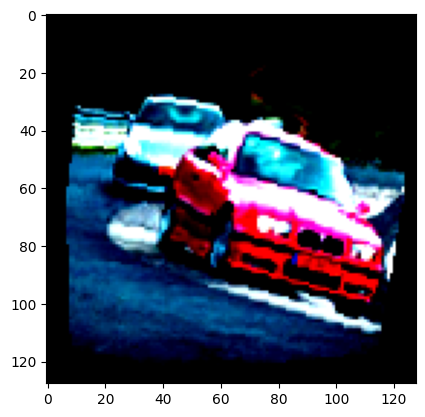

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-43.5046, -31.6912, -13.0446, -10.3464, -25.9609, -37.9102, -28.5557,
         -31.5711, -36.4172, -41.3480, -39.0422, -38.5185, -43.7529, -32.0207]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.2770e-19, 1.7245e-14, 2.1616e-06, 3.2106e-05, 5.3130e-12, 3.4342e-17,
         3.9664e-13, 1.9447e-14, 1.5283e-16, 1.1036e-18, 1.1071e-17, 1.8691e-17,
         9.9621e-20, 1.2405e-14]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


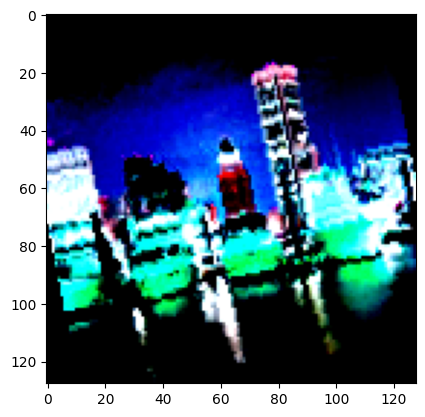

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[ -6.4265,  -9.4589,  -3.5674,  -8.6877,  -7.2892,  -4.6254,  -6.7160,
          -7.3564,   3.6212,  -4.4235,  -6.7596, -11.2008, -10.1186,  -6.3178]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.6155e-03, 7.7984e-05, 2.7453e-02, 1.6863e-04, 6.8242e-04, 9.7050e-03,
         1.2099e-03, 6.3809e-04, 9.7395e-01, 1.1850e-02, 1.1584e-03, 1.3663e-05,
         4.0322e-05, 1.8007e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


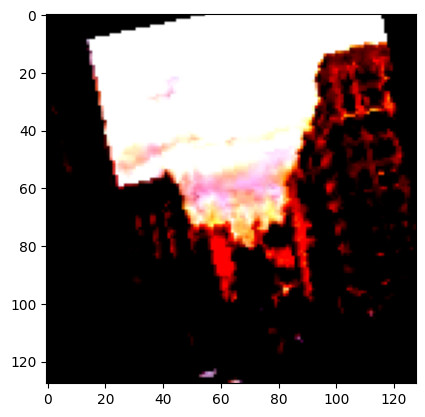

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-10.3018, -10.2102,   0.1136,  -8.8782,  -7.0738,  -7.7424,  -7.3359,
          -6.0274,  -7.9786,  -7.2159,  -9.7808, -10.0959, -10.5586,  -9.4554]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[3.3570e-05, 3.6793e-05, 5.2838e-01, 1.3938e-04, 8.4632e-04, 4.3385e-04,
         6.5129e-04, 2.4059e-03, 3.4260e-04, 7.3424e-04, 5.6524e-05, 4.1245e-05,
         2.5970e-05, 7.8262e-05]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


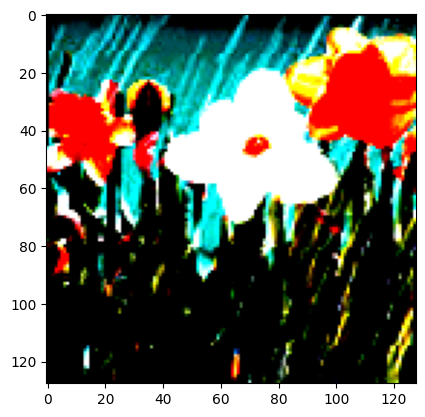

raw: tensor([[ -7.9044, -10.0066,  -3.3222,  -7.6763,  -6.3869,  -0.8206,  -5.0139,
          -0.3664,  -7.7468,  -0.3291,  -9.4085,  -9.3027,  -8.8404,  -8.6514]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[3.6899e-04, 4.5099e-05, 3.4817e-02, 4.6345e-04, 1.6806e-03, 3.0563e-01,
         6.6011e-03, 4.0942e-01, 4.3192e-04, 4.1846e-01, 8.2014e-05, 9.1168e-05,
         1.4475e-04, 1.7485e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


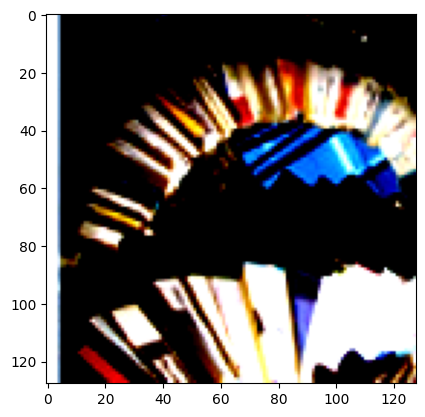

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-6.5187, -7.2127, -4.8154, -3.8455, -5.0182,  0.9853, -1.6833,  0.9618,
         -5.2857,  1.3672, -9.2972, -8.3337, -6.7723, -7.2424]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.4734e-03, 7.3663e-04, 8.0386e-03, 2.0929e-02, 6.5727e-03, 7.2816e-01,
         1.5666e-01, 7.2349e-01, 5.0382e-03, 7.9693e-01, 9.1669e-05, 2.4023e-04,
         1.1438e-03, 7.1511e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)


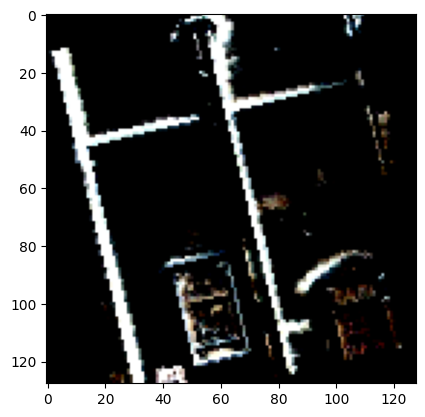

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-11.9409,  -8.3135,  -0.1141,  -5.4007,  -8.2633, -10.9357,  -1.8378,
         -12.5357,  -8.9299, -11.3282, -11.4959,  -7.3006, -11.0748,  -9.1121]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[6.5180e-06, 2.4512e-04, 4.7152e-01, 4.4932e-03, 2.5774e-04, 1.7811e-05,
         1.3732e-01, 3.5960e-06, 1.3235e-04, 1.2028e-05, 1.0172e-05, 6.7468e-04,
         1.5498e-05, 1.1031e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


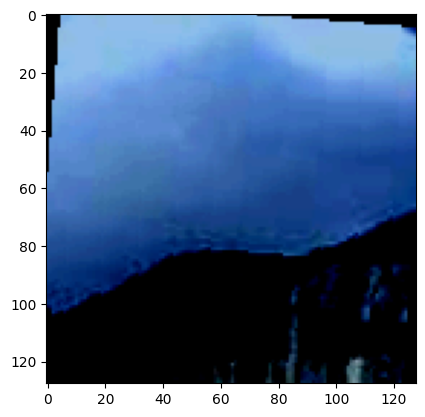

raw: tensor([[-4.2074, -6.4565, -1.6126, -5.4352, -5.1742, -2.8635, -4.5851, -3.8178,
         -0.2682, -2.2611, -3.2471, -6.8105, -6.4356, -4.7062]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0147, 0.0016, 0.1662, 0.0043, 0.0056, 0.0540, 0.0101, 0.0215, 0.4333,
         0.0944, 0.0374, 0.0011, 0.0016, 0.0090]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


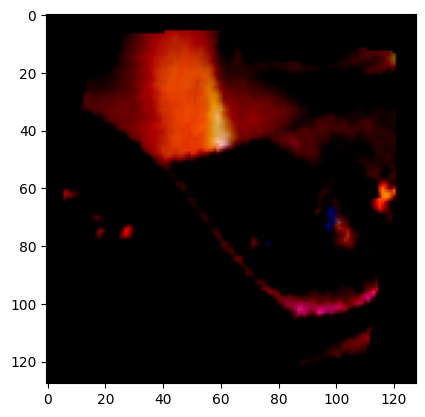

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-4.9676, -7.3811, -1.9690, -6.7572, -5.9092, -2.8607, -5.6531, -5.8004,
         -0.0134, -2.6276, -3.2262, -7.4105, -7.2526, -5.7000]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0069, 0.0006, 0.1225, 0.0012, 0.0027, 0.0541, 0.0035, 0.0030, 0.4966,
         0.0674, 0.0382, 0.0006, 0.0007, 0.0033]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


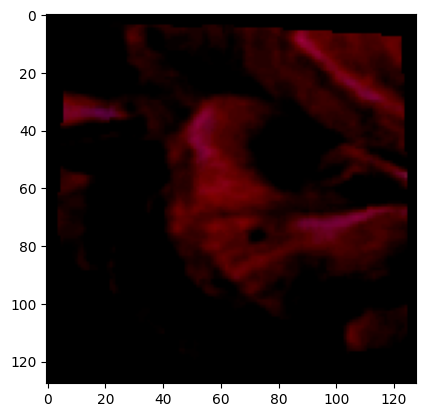

raw: tensor([[ -6.5558, -10.2549,  -5.0696,  -8.8729,  -6.5826,  -1.7735,  -4.3795,
          -3.9475,   1.2828,  -1.5910,  -4.7505, -10.7443,  -9.8967,  -7.4736]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.4198e-03, 3.5184e-05, 6.2454e-03, 1.4012e-04, 1.3824e-03, 1.4511e-01,
         1.2377e-02, 1.8938e-02, 7.8292e-01, 1.6924e-01, 8.5736e-03, 2.1569e-05,
         5.0336e-05, 5.6756e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


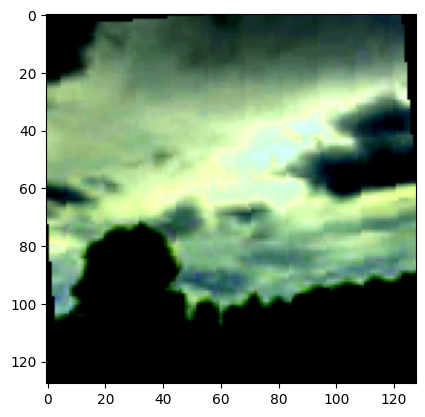

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[ -8.2362,  -7.5264,  -6.6695,   1.3769,  -7.6294,  -8.5816,  -5.2640,
          -8.5108,  -8.8376,  -9.2990, -13.1082,  -7.4106,  -8.8786,  -9.2891]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[2.6482e-04, 5.3839e-04, 1.2674e-03, 7.9850e-01, 4.8570e-04, 1.8749e-04,
         5.1481e-03, 2.0125e-04, 1.4515e-04, 9.1510e-05, 2.0286e-06, 6.0446e-04,
         1.3932e-04, 9.2416e-05]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


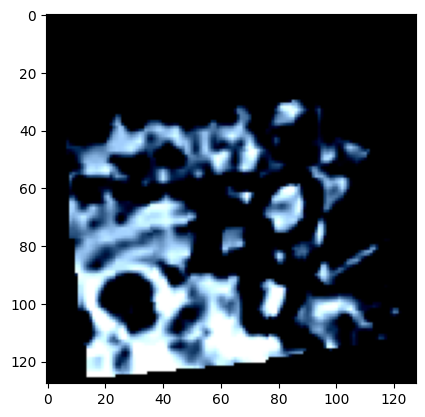

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-3.0003, -4.4115, -0.5806, -3.3204, -3.1910, -0.8090, -5.1059, -1.5006,
         -2.4469, -0.2616, -1.0710, -3.2519, -4.6206, -3.8206]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0474, 0.0120, 0.3588, 0.0349, 0.0395, 0.3081, 0.0060, 0.1823, 0.0797,
         0.4350, 0.2552, 0.0373, 0.0098, 0.0214]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


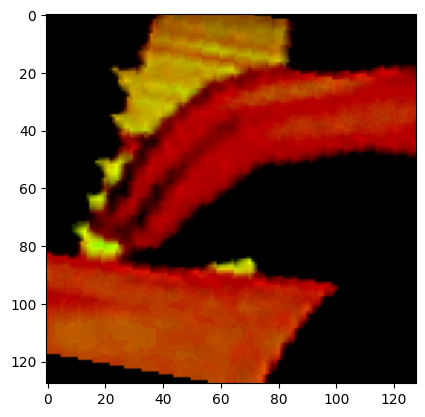

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-3.9800, -4.3367, -1.3130, -5.3017, -3.0575,  0.1475, -2.5219, -0.2985,
         -4.2747, -0.2158, -0.9116, -3.6840, -4.2940, -3.8110]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0183, 0.0129, 0.2120, 0.0050, 0.0449, 0.5368, 0.0743, 0.4259, 0.0137,
         0.4463, 0.2867, 0.0245, 0.0135, 0.0216]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


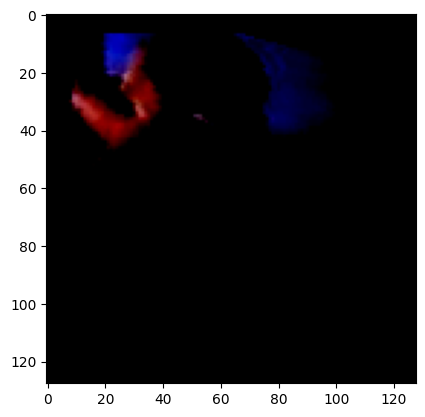

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-70.8618, -55.1869,  -6.4524, -15.7574, -50.8592, -70.5052, -36.0627,
         -63.0058, -52.5063, -71.9822, -55.7406, -52.9645, -68.5237, -53.3459]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.6792e-31, 1.0781e-24, 1.5743e-03, 1.4344e-07, 8.1680e-23, 2.3987e-31,
         2.1786e-16, 4.3344e-28, 1.5733e-23, 5.4766e-32, 6.1968e-25, 9.9497e-24,
         1.7399e-30, 6.7944e-24]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


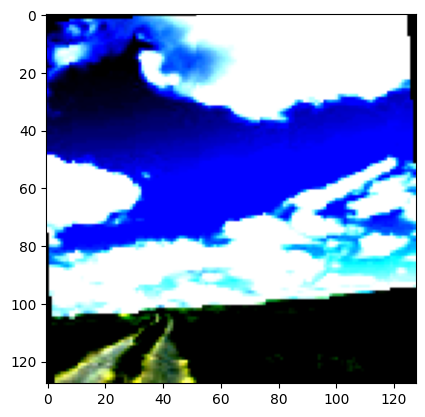

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-13.5290, -13.2387,   2.7738, -10.5535,  -9.8960, -10.1810,  -9.3524,
         -12.2384,  -7.9561, -10.6090, -10.7737, -12.1079, -13.9887, -12.5079]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.3317e-06, 1.7803e-06, 9.4125e-01, 2.6101e-05, 5.0371e-05, 3.7882e-05,
         8.6747e-05, 4.8409e-06, 3.5038e-04, 2.4692e-05, 2.0942e-05, 5.5157e-06,
         8.4094e-07, 3.6974e-06]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


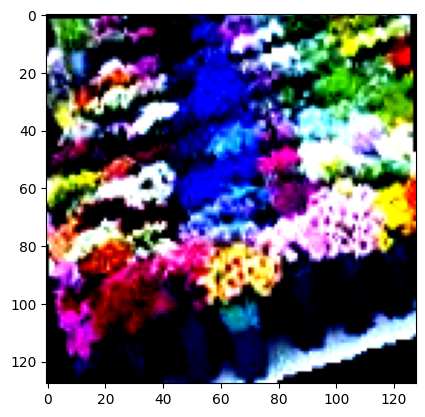

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-6.2720, -6.7554, -0.9822, -8.2821, -4.7149, -3.5684, -2.7088, -3.8103,
         -3.1647, -3.1154, -4.8370, -7.4161, -7.4845, -5.6522]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.8850e-03, 1.1632e-03, 2.7245e-01, 2.5294e-04, 8.8816e-03, 2.7427e-02,
         6.2456e-02, 2.1663e-02, 4.0514e-02, 4.2477e-02, 7.8687e-03, 6.0115e-04,
         5.6142e-04, 3.4974e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


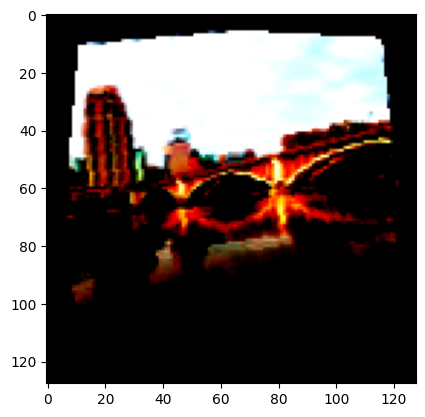

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-6.3015, -8.4553, -1.6658, -6.7689, -6.8547, -5.1553, -3.6163, -5.7099,
         -3.0082, -5.1069, -7.6367, -8.7201, -8.1632, -7.3797]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0018, 0.0002, 0.1590, 0.0011, 0.0011, 0.0057, 0.0262, 0.0033, 0.0471,
         0.0060, 0.0005, 0.0002, 0.0003, 0.0006]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


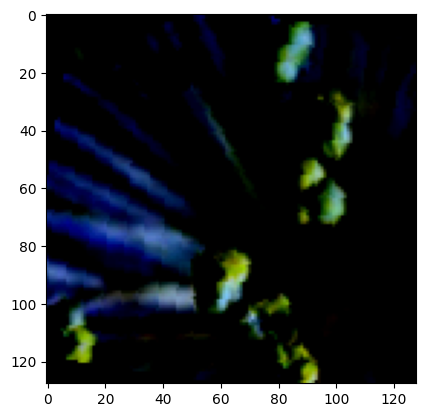

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-10.3058, -10.9289,  -0.8723,  -6.7297,  -7.6071,  -8.1776,  -8.9440,
          -8.2670,  -6.2524,  -7.7764, -11.0152, -11.2920, -10.2386,  -8.3251]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[3.3438e-05, 1.7932e-05, 2.9478e-01, 1.1935e-03, 4.9667e-04, 2.8080e-04,
         1.3049e-04, 2.5678e-04, 1.9221e-03, 4.1933e-04, 1.6450e-05, 1.2472e-05,
         3.5761e-05, 2.4230e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


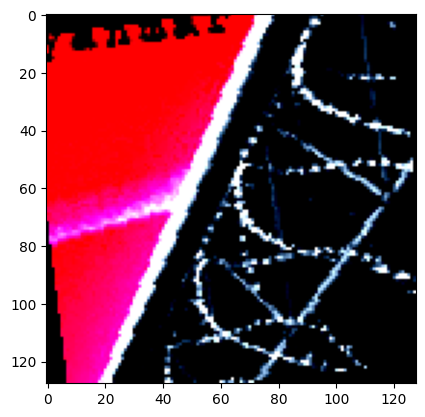

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[ -9.4510, -13.2229,  -5.1548, -12.2029,  -8.1739,  -2.5592,  -9.4761,
          -5.8025,   2.1227,  -2.1213,  -5.8249, -13.9036, -12.9487,  -9.1514]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[7.8602e-05, 1.8087e-06, 5.7386e-03, 5.0156e-06, 2.8185e-04, 7.1812e-02,
         7.6656e-05, 3.0108e-03, 8.9309e-01, 1.0705e-01, 2.9443e-03, 9.1565e-07,
         2.3794e-06, 1.0606e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


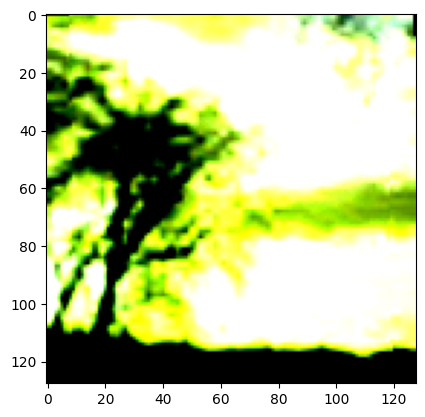

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-10.9693,  -9.4349,  -4.4261,  -0.5361,  -7.8866,  -9.7536,  -7.2392,
          -7.7971, -10.9121, -10.0372,  -9.5806,  -8.0214, -11.5259,  -9.0677]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.7222e-05, 7.9877e-05, 1.1820e-02, 3.6909e-01, 3.7561e-04, 5.8083e-05,
         7.1737e-04, 4.1074e-04, 1.8235e-05, 4.3740e-05, 6.9052e-05, 3.2825e-04,
         9.8714e-06, 1.1532e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


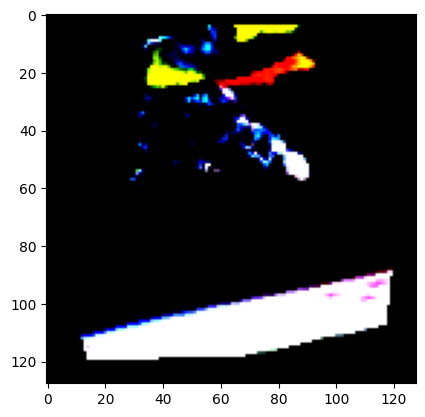

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-4.5257, -5.7786, -2.7565, -5.0021, -3.8505,  0.7878, -1.4635,  0.6112,
         -2.5874,  1.3483, -5.4006, -7.4763, -6.1307, -4.6118]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.0711e-02, 3.0835e-03, 5.9723e-02, 6.6790e-03, 2.0826e-02, 6.8736e-01,
         1.8794e-01, 6.4822e-01, 6.9956e-02, 7.9386e-01, 4.4934e-03, 5.6601e-04,
         2.1704e-03, 9.8359e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)


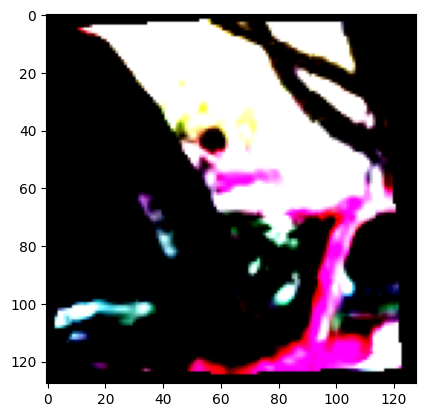

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[ -7.2596, -10.0781,  -4.8968,  -8.0976,  -6.7422,  -3.5203,  -6.2289,
          -6.6153,   3.7575,  -3.7802,  -5.8723, -11.0513,  -9.2170,  -7.5244]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[7.0290e-04, 4.1988e-05, 7.4152e-03, 3.0417e-04, 1.1787e-03, 2.8739e-02,
         1.9678e-03, 1.3379e-03, 9.7719e-01, 2.2309e-02, 2.8084e-03, 1.5867e-05,
         9.9327e-05, 5.3946e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


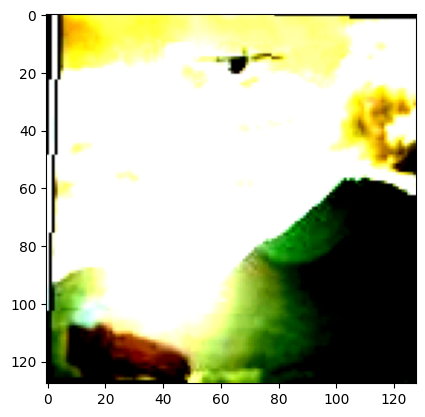

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-3.8750, -5.1768, -2.8175, -3.4835, -3.7229,  1.0477, -3.2505, -0.0451,
         -4.3155,  1.1310, -0.9101, -3.6082, -4.9533, -4.6265]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0203, 0.0056, 0.0564, 0.0298, 0.0236, 0.7403, 0.0373, 0.4887, 0.0132,
         0.7560, 0.2870, 0.0264, 0.0070, 0.0097]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)


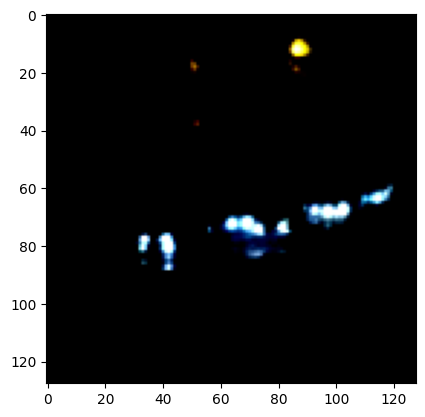

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[-120.8682,  -94.8426,  -30.9935,  -16.8651,  -82.9362, -123.7497,
          -82.1644, -117.5070, -105.0560, -133.3845, -116.9283, -101.5136,
         -123.5836,  -99.8296]], grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0000e+00, 0.0000e+00, 3.4651e-14, 4.7380e-08, 9.5773e-37, 0.0000e+00,
         2.0724e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


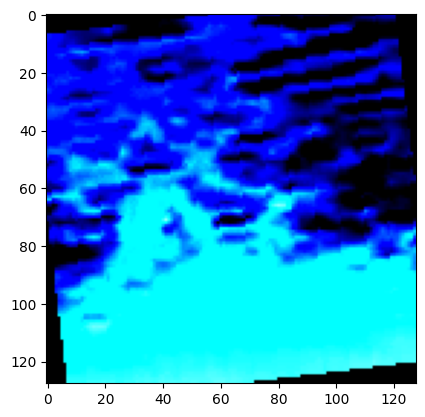

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


raw: tensor([[ -6.8558, -10.2498,  -3.6549,  -9.5578,  -6.8136,  -1.5871,  -6.8755,
          -2.8593,  -4.1609,  -1.3916,  -5.4618,  -8.8885,  -9.4627,  -7.6345]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.0523e-03, 3.5365e-05, 2.5213e-02, 7.0640e-05, 1.0975e-03, 1.6979e-01,
         1.0317e-03, 5.4202e-02, 1.5354e-02, 1.9915e-01, 4.2279e-03, 1.3794e-04,
         7.7688e-05, 4.8324e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


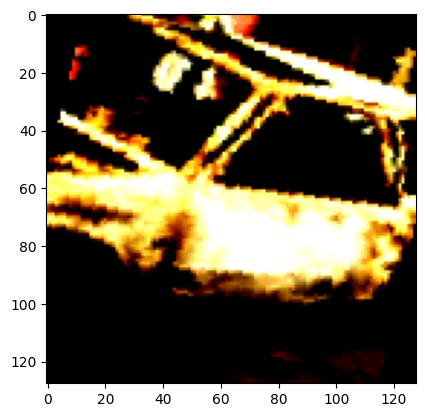

In [142]:
def testN(num_pics):
    test_total = 0
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    for i, data in enumerate(test_loader):
        test_total += 1
        if test_total > num_pics:
            break
        input, label, index, path = data
        input, label = input.to(device), label.to(device)
        output = model.forward(input)
        predictions = (torch.sigmoid(output) > 0.5).int()
        print(f'raw: {output}, sigmoid: {torch.sigmoid(output)}')
        print(['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree'])
        print('label',label)
        print()
        print('pred', predictions)

        image_array = input.numpy()
        plt.imshow(image_array.transpose((2, 3, 1, 0)).squeeze(3))
        plt.show()


testN(25)